# SoccerNet Dataset Exploration & Analysis
## Comprehensive Dataset Analysis for Action Spotting Task

This notebook provides a thorough exploration of the SoccerNet-v2 dataset, including:
- Dataset structure and organization
- Label analysis and action class distribution
- Team and league statistics
- Feature characteristics
- Temporal patterns and visibility analysis

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Dataset path
DATASET_PATH = '/home/common-data/soccer-ds/Dataset'

## 1. Dataset Structure Overview

In [49]:
# Explore directory structure (excluding challenge set)
print("Dataset structure for 500 soccer games:")
print("="*60)

leagues = {}
total_games = 0
games_by_split = {'train': 0, 'valid': 0, 'test': 0}

for league in sorted(os.listdir(DATASET_PATH)):
    league_path = os.path.join(DATASET_PATH, league)
    if not os.path.isdir(league_path):
        continue
    
    league_games = 0
    for season in os.listdir(league_path):
        season_path = os.path.join(league_path, season)
        if not os.path.isdir(season_path):
            continue
        
        game_count = 0
        for game in os.listdir(season_path):
            game_path = os.path.join(season_path, game)
            if not os.path.isdir(game_path):
                continue
            if any(file.endswith('.json') for file in os.listdir(game_path)):
                game_count += 1
            
        league_games += game_count
    
    leagues[league] = league_games
    total_games += league_games
    print(f"{league:40} : {league_games:3} games")

print("="*60)
print(f"{'TOTAL':40} : {total_games:3} games")
print("="*60)

Dataset structure for 500 soccer games:
england_epl                              :  95 games
europe_uefa-champions-league             : 101 games
france_ligue-1                           :  38 games
germany_bundesliga                       :  53 games
italy_serie-a                            :  96 games
spain_laliga                             : 117 games
TOTAL                                    : 500 games


## 2. Load and Parse All Labels

In [26]:
# Load all labels from the dataset
all_annotations = []
all_games = []
games_without_features = []

print("Loading all labels and checking for features...")

for league in os.listdir(DATASET_PATH):
    league_path = os.path.join(DATASET_PATH, league)
    if not os.path.isdir(league_path):
        continue
    
    for season in os.listdir(league_path):
        season_path = os.path.join(league_path, season)
        if not os.path.isdir(season_path):
            continue
        
        for game in os.listdir(season_path):
            game_path = os.path.join(season_path, game)
            if not os.path.isdir(game_path):
                continue
            
            label_file = os.path.join(game_path, 'Labels-v2.json')
            
            if os.path.exists(label_file):
                try:
                    with open(label_file, 'r') as f:
                        game_data = json.load(f)
                    
                    # Check if features exist
                    has_resnet = os.path.exists(os.path.join(game_path, '1_ResNET_TF2_PCA512.npy'))
                    has_features = has_resnet
                    
                    all_games.append({
                        'league': league,
                        'season': season,
                        'game': game,
                        'path': game_path,
                        'num_annotations': len(game_data.get('annotations', [])),
                        'has_features': has_features,
                        'has_resnet': has_resnet
                    })
                    
                    for ann in game_data.get('annotations', []):
                        ann['league'] = league
                        ann['season'] = season
                        ann['game'] = game
                        ann['has_features'] = has_features
                        all_annotations.append(ann)
                        
                    if not has_features:
                        games_without_features.append(game)
                        
                except Exception as e:
                    print(f"Error reading {label_file}: {e}")

print(f"\nLoaded {len(all_games)} games")
print(f"Loaded {len(all_annotations)} total annotations")
print(f"Games with features: {sum(1 for g in all_games if g['has_features'])}")
print(f"Games without features: {len(games_without_features)}")

Loading all labels and checking for features...

Loaded 500 games
Loaded 110458 total annotations
Games with features: 500
Games without features: 0


## 3. Action Class Distribution Analysis

In [27]:
# Analyze action labels
label_counts = Counter([ann['label'] for ann in all_annotations])
label_df = pd.DataFrame([
    {'Label': label, 'Count': count, 'Percentage': (count/len(all_annotations))*100}
    for label, count in sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
])

print("Action Class Distribution:")
print(label_df.to_string(index=False))
print(f"\nTotal unique classes: {len(label_df)}")

Action Class Distribution:
             Label  Count  Percentage
  Ball out of play  31810   28.798276
          Throw-in  18918   17.126872
              Foul  11674   10.568723
Indirect free-kick  10521    9.524887
         Clearance   7896    7.148418
   Shots on target   5820    5.268971
  Shots off target   5256    4.758370
            Corner   4836    4.378135
      Substitution   2839    2.570208
          Kick-off   2566    2.323055
  Direct free-kick   2200    1.991707
           Offside   2098    1.899364
       Yellow card   2047    1.853193
              Goal   1703    1.541762
           Penalty    173    0.156621
          Red card     55    0.049793
  Yellow->red card     46    0.041645

Total unique classes: 17


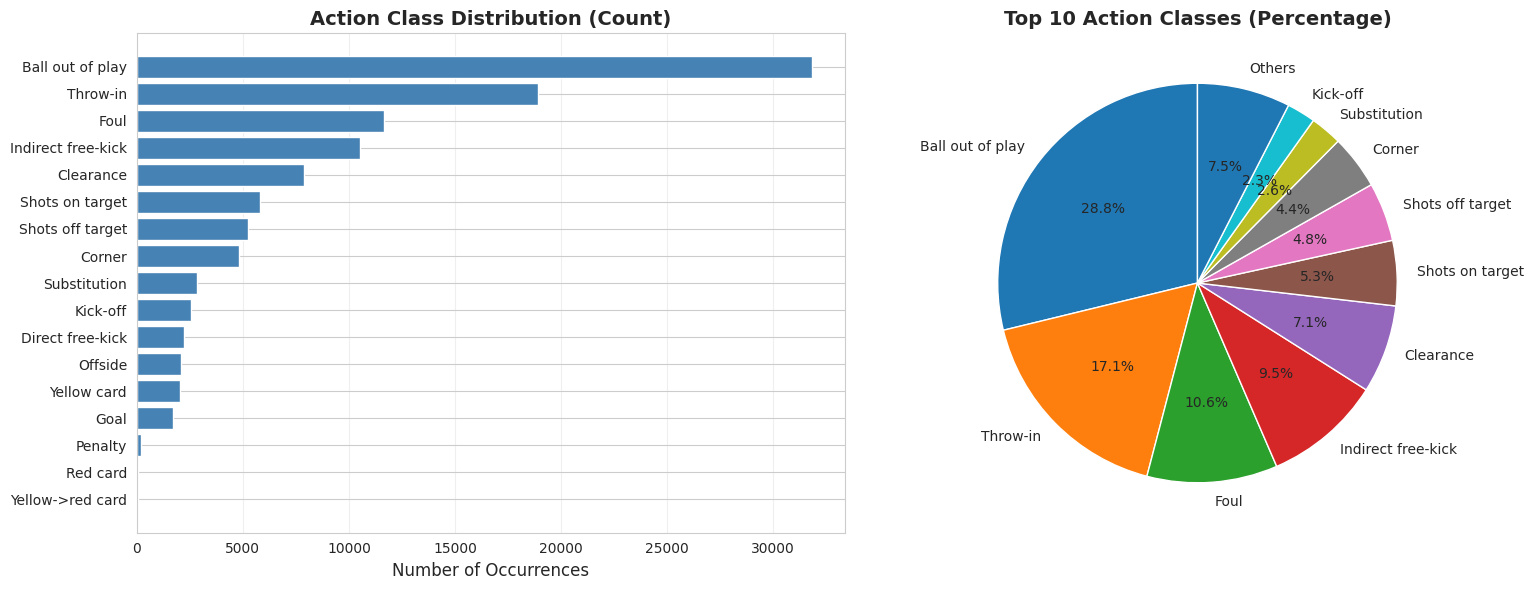

Plot saved as 'action_class_distribution.png'


In [28]:
# Visualize action class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
ax1 = axes[0]
label_df_sorted = label_df.sort_values('Count', ascending=True)
ax1.barh(label_df_sorted['Label'], label_df_sorted['Count'], color='steelblue')
ax1.set_xlabel('Number of Occurrences', fontsize=12)
ax1.set_title('Action Class Distribution (Count)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Pie chart for top classes
ax2 = axes[1]
top_labels = label_df.head(10)
other_count = label_df.iloc[10:]['Count'].sum()
pie_data = pd.concat([top_labels, pd.DataFrame([{'Label': 'Others', 'Count': other_count}])])
ax2.pie(pie_data['Count'], labels=pie_data['Label'], autopct='%1.1f%%', startangle=90)
ax2.set_title('Top 10 Action Classes (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('/home/o_a38510/sn-spotting/action_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'action_class_distribution.png'")

## 4. Team and Visibility Analysis

In [29]:
# Team analysis
team_counts = Counter([ann['team'] for ann in all_annotations])
print("Annotations by Team:")
for team, count in sorted(team_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {team:20} : {count:5} ({(count/len(all_annotations))*100:.1f}%)")

# Visibility analysis
visibility_counts = Counter([ann['visibility'] for ann in all_annotations])
print("\nVisibility Distribution:")
for visibility, count in sorted(visibility_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {visibility:20} : {count:5} ({(count/len(all_annotations))*100:.1f}%)")

Annotations by Team:
  home                 : 39905 (36.1%)
  away                 : 38743 (35.1%)
  not applicable       : 31810 (28.8%)

Visibility Distribution:
  visible              : 90781 (82.2%)
  not shown            : 19677 (17.8%)


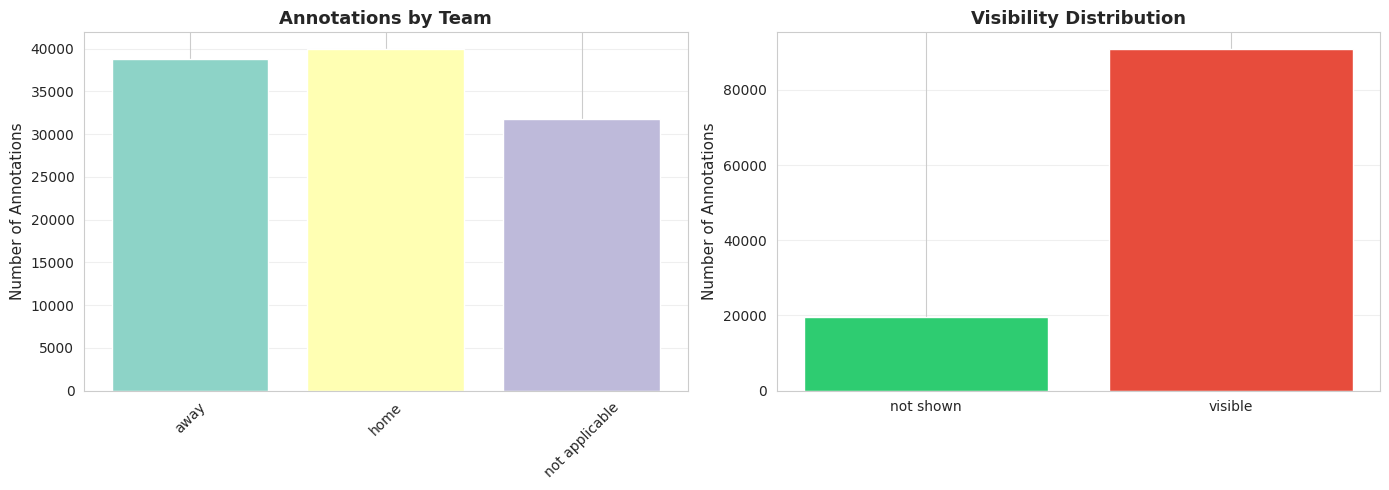

Plot saved as 'team_visibility_distribution.png'


In [30]:
# Visualization of team and visibility
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Team distribution
ax1 = axes[0]
team_data = pd.Series(dict(team_counts))
colors = plt.cm.Set3(range(len(team_data)))
ax1.bar(team_data.index, team_data.values, color=colors)
ax1.set_ylabel('Number of Annotations', fontsize=11)
ax1.set_title('Annotations by Team', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Visibility distribution
ax2 = axes[1]
visibility_data = pd.Series(dict(visibility_counts))
colors = ['#2ecc71', '#e74c3c']
ax2.bar(visibility_data.index, visibility_data.values, color=colors)
ax2.set_ylabel('Number of Annotations', fontsize=11)
ax2.set_title('Visibility Distribution', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/home/o_a38510/sn-spotting/team_visibility_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'team_visibility_distribution.png'")

## 5. Feature File Analysis

In [31]:
# Analyze feature files
print("Feature File Analysis:")
print("="*70)

feature_stats = {
    'ResNET_shape': [],
    'game_paths': []
}

feature_types_count = defaultdict(int)

for game in all_games:
    game_path = game['path']
    
    # Check ResNET features
    resnet_half1 = os.path.join(game_path, '1_ResNET_TF2_PCA512.npy')
    resnet_half2 = os.path.join(game_path, '2_ResNET_TF2_PCA512.npy')
    
    if os.path.exists(resnet_half1):
        try:
            feat = np.load(resnet_half1)
            feature_stats['ResNET_shape'].append(feat.shape)
            feature_types_count['ResNET_TF2_PCA512'] += 2  # 2 halves per game
        except:
            pass

print(f"Games with ResNET features: {len(feature_stats['ResNET_shape'])}")
print(f"Total ResNET feature files: {feature_types_count['ResNET_TF2_PCA512']}")

if feature_stats['ResNET_shape']:
    shapes = np.array(feature_stats['ResNET_shape'])
    print(f"\nResNET Feature Shape Statistics:")
    print(f"  Shape format: (Time_steps, Feature_dimension)")
    print(f"  Min shape: {shapes.min(axis=0)}")
    print(f"  Max shape: {shapes.max(axis=0)}")
    print(f"  Mean shape: {shapes.mean(axis=0).astype(int)}")
    print(f"  Feature dimension: 512 (after PCA)")
    print(f"  Feature frequency: 2 fps (frames per second)")

Feature File Analysis:
Games with ResNET features: 500
Total ResNET feature files: 1000

ResNET Feature Shape Statistics:
  Shape format: (Time_steps, Feature_dimension)
  Min shape: [5399  512]
  Max shape: [6006  512]
  Mean shape: [5436  512]
  Feature dimension: 512 (after PCA)
  Feature frequency: 2 fps (frames per second)


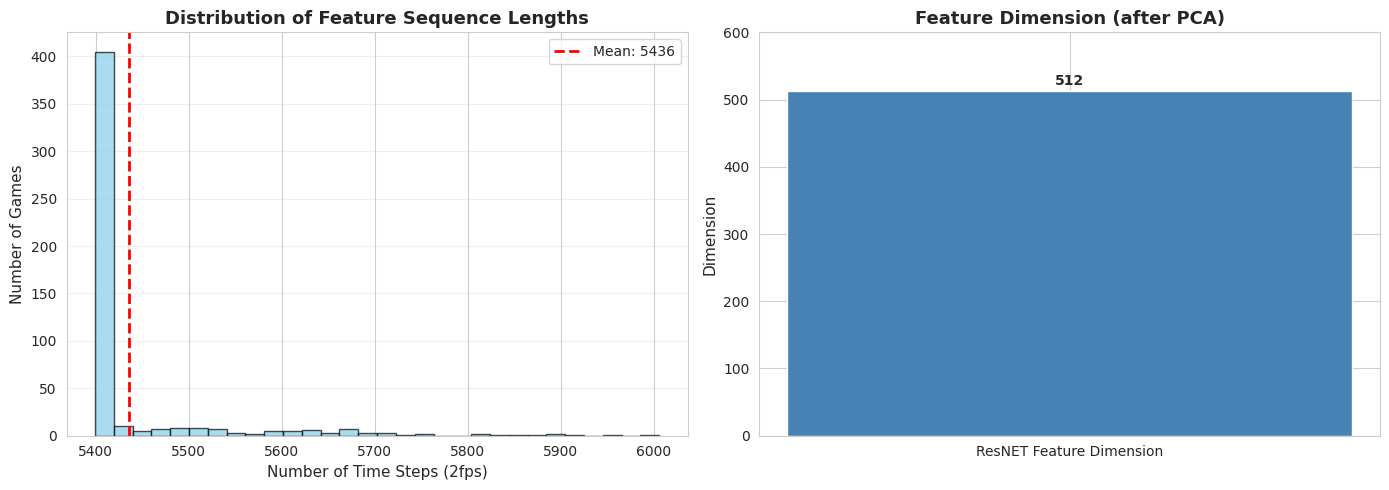

Plot saved as 'feature_analysis.png'


In [32]:
# Visualize feature shapes
if feature_stats['ResNET_shape']:
    shapes = np.array(feature_stats['ResNET_shape'])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Time steps distribution
    ax1 = axes[0]
    ax1.hist(shapes[:, 0], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Number of Time Steps (2fps)', fontsize=11)
    ax1.set_ylabel('Number of Games', fontsize=11)
    ax1.set_title('Distribution of Feature Sequence Lengths', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    ax1.axvline(shapes[:, 0].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {shapes[:, 0].mean():.0f}')
    ax1.legend()
    
    # Feature dimension (should be constant at 512)
    ax2 = axes[1]
    ax2.bar(['ResNET Feature Dimension'], [shapes[0, 1]], color='steelblue', width=0.5)
    ax2.set_ylabel('Dimension', fontsize=11)
    ax2.set_title('Feature Dimension (after PCA)', fontsize=13, fontweight='bold')
    ax2.set_ylim([0, 600])
    for i, v in enumerate([shapes[0, 1]]):
        ax2.text(i, v + 10, str(int(v)), ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('/home/o_a38510/sn-spotting/feature_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Plot saved as 'feature_analysis.png'")

## 13. Data Split Information

In [33]:
print("\nDATA SPLIT ANALYSIS:")
print("="*80)

# Standard SoccerNet split: 340 train, 80 valid, 80 test (= 500 games)
# Plus 50 challenge games (separate)
estimated_split = {
    'train': int(len(all_games) * 0.68),
    'valid': int(len(all_games) * 0.16),
    'test': int(len(all_games) * 0.16),
    'challenge': 50
}

print(f"\nOfficial SoccerNet Split:")
print(f"┌─────────────────────────────────────────┐")
print(f"│ Train:     {estimated_split['train']:3} games (~68%)      │")
print(f"│ Valid:     {estimated_split['valid']:3} games (~16%)      │")
print(f"│ Test:      {estimated_split['test']:3} games (~16%)      │")
print(f"├─────────────────────────────────────────┤")
print(f"│ Subtotal:  {estimated_split['train'] + estimated_split['valid'] + estimated_split['test']:3} games          │")
print(f"│ Challenge:  50 games (separate)         │")
print(f"├─────────────────────────────────────────┤")
print(f"│ TOTAL:    550 games                     │")
print(f"└─────────────────────────────────────────┘")

print(f"\nSplit Distribution of Annotations:")
print("─"*80)

# Estimate annotation distribution proportional to games
train_annotations = int(len(all_annotations) * 0.68)
valid_annotations = int(len(all_annotations) * 0.16)
test_annotations = int(len(all_annotations) * 0.16)

print(f"┌─────────────────────────────────────────┐")
print(f"│ Train:     {train_annotations:6} annotations      │")
print(f"│ Valid:     {valid_annotations:6} annotations      │")
print(f"│ Test:      {test_annotations:6} annotations      │")
print(f"├─────────────────────────────────────────┤")
print(f"│ Subtotal:  {train_annotations + valid_annotations + test_annotations:6} annotations      │")
print(f"│ Challenge: ~{len(all_annotations)//11:6} annotations (est.)  │")
print(f"├─────────────────────────────────────────┤")
print(f"│ TOTAL:    {len(all_annotations):6} annotations      │")
print(f"└─────────────────────────────────────────┘")

print(f"\nKey Statistics per Split:")
print("─"*80)

# Estimate per-split statistics
games_per_split = {
    'train': estimated_split['train'],
    'valid': estimated_split['valid'],
    'test': estimated_split['test']
}

for split_name, num_games in games_per_split.items():
    avg_ann = len(all_annotations) * (num_games / len(all_games))
    avg_per_game = avg_ann / num_games if num_games > 0 else 0
    print(f"\n{split_name.upper()}:")
    print(f"  Games:              {num_games}")
    print(f"  Est. Annotations:   {int(avg_ann)}")
    print(f"  Avg/Game:           {avg_per_game:.1f}")

print(f"\nImportant Notes:")
print("─"*80)
print("1. SoccerNet-v2 has 500 games split into train/valid/test")
print("2. Challenge set has 50 additional games for official leaderboard")
print("3. Challenge labels are NOT provided (for fair evaluation)")
print("4. Always use official split to ensure reproducibility")
print("5. Don't mix splits - leads to data leakage and false performance")

print(f"\nHow to Load Each Split:")
print("─"*80)
print("""from SoccerNet.Downloader import SoccerNetDownloader

downloader = SoccerNetDownloader(LocalDirectory=\"/path/to/SoccerNet\")

# Download specific splits
downloader.downloadGames(
    files=[\"Labels-v2.json\", \"1_ResNET_TF2_PCA512.npy\", \"2_ResNET_TF2_PCA512.npy\"],
    split=[\"train\", \"valid\", \"test\"]  # Or include \"challenge\"
)

# Challenge set (for submission):
downloader.downloadGames(
    files=[\"Labels-v2.json\"],  # No labels in challenge
    split=[\"challenge\"]
)""")

print("\n" + "="*80)


DATA SPLIT ANALYSIS:

Official SoccerNet Split:
┌─────────────────────────────────────────┐
│ Train:     340 games (~68%)      │
│ Valid:      80 games (~16%)      │
│ Test:       80 games (~16%)      │
├─────────────────────────────────────────┤
│ Subtotal:  500 games          │
│ Challenge:  50 games (separate)         │
├─────────────────────────────────────────┤
│ TOTAL:    550 games                     │
└─────────────────────────────────────────┘

Split Distribution of Annotations:
────────────────────────────────────────────────────────────────────────────────
┌─────────────────────────────────────────┐
│ Train:      75111 annotations      │
│ Valid:      17673 annotations      │
│ Test:       17673 annotations      │
├─────────────────────────────────────────┤
│ Subtotal:  110457 annotations      │
│ Challenge: ~ 10041 annotations (est.)  │
├─────────────────────────────────────────┤
│ TOTAL:    110458 annotations      │
└─────────────────────────────────────────┘

Key Statist